In [1]:
# Packages
############################
'''
Template for the 4th assignment
Student: Fabian Gobet
'''
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

from accelerate import Accelerator
import torch
import torch.nn as nn
import math
import random
import re
import statistics
from nltk.tokenize.treebank import TreebankWordTokenizer
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

In [2]:
# Classes
############################
# Vocabulary class
class Vocabulary:
    '''
    Class for dealing with our corpus
    '''

    def __init__(self, name, sentences):
        """
        Args:
            name (str): name of the language
            pairs (list): list of pairs of sentences
        """
        self.name = name
        self.word2index = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>"}
        for s in sentences:
            self.add_sentence(s)


    def add_word(self, word):
        '''
        Add a word to the vocabulary
        :param word: a string
        '''
        # TODO: add the word to the vocabulary
        if not word in self.word2index:
            self.word2index[word] = len(self.word2index)
            self.index2word[len(self.index2word)] = word


    def add_sentence(self, sentence):
        '''
        Add a sentence to the vocabulary
        :param sentence: list of strings (words)
        '''
        # TODO add the sentence to the vocabulary, this method will call the add_word method
        for word in sentence:
            self.add_word(word)


# Dataset class
class Dataset(torch.utils.data.Dataset):
    def __init__(self, vocabulary, pairs_refs, sentences):
        # TODO We want vocabulary and pairs to be attributes of the class
        self.vocabulary = vocabulary
        self.pairs = pairs_refs
        self.sentences = sentences

    def __len__(self):
        # TODO how many pairs do we have?
        return len(self.pairs)

    def __getitem__(self, ix):
        # TODO returns two tensors (question, answer) of the pair at index ix
        # TODO the tensors should be of type torch.tensor and should contain integers (word indices)
        q,a = self.pairs[ix]
        q = torch.tensor([self.vocabulary.word2index[word] for word in self.sentences[q]])
        a = torch.tensor([self.vocabulary.word2index[word] for word in ["<SOS>"]+self.sentences[a]])
        return q,a


class PositionalEncoding(nn.Module):
    '''
    Adapted from
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    '''
    def __init__(self, d_model, dropout=0.0, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.max_len = max_len

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float()
                             * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        try:
            assert x.size(0) < self.max_len
        except:
            print("The length of the sequence is bigger than the max_len of the positional encoding. Increase the max_len or provide a shorter sequence.")
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model=512, pad_id=0, encoder_layers=6, decoder_layers=6, dim_feedforward=2048, num_heads=8, dropout_transformer=0.1, dropout_posenconding=0):
        super().__init__()

        # TODO add an embedding layer
        self.embedding = nn.Embedding(vocab_size, d_model)

        # TODO add a positional encoding layer
        self.pos_encoder = PositionalEncoding(d_model,dropout=dropout_posenconding)

        # TODO add a transformer layer, you can use nn.Transformer. You can use the default values for the parameters, but what about batch_first?
        self.transformer = nn.Transformer(d_model=d_model, nhead=num_heads, num_encoder_layers=encoder_layers, 
                                          num_decoder_layers=decoder_layers, dim_feedforward=dim_feedforward, dropout=dropout_transformer, 
                                          batch_first=True)

        # TODO add a linear layer. Note: output should be probability distribution over the vocabulary
        self.linear = nn.Linear(d_model, vocab_size)

        # Stuff you may need
        self.vocab_size = vocab_size
        self.pad_id = pad_id
        self.num_heads = num_heads

    def create_padding_mask(self, x, pad_id=0):
        # TODO create a boolean mask for the <PAD> tokens
        return x.eq(pad_id)

    def forward(self, src, tgt):
        # S is the source sequence length, T is the target sequence length, N is the batch size, E is the feature number
        # src: (N, S)
        # tgt: (N, T)
        # src_pad_mask: (N, S)
        # tgt_pad_mask: (N, T)
        # mask the future : (N * num_heads, T, T)

        src_pad_mask = self.create_padding_mask(src, self.pad_id) # (N, S)
        tgt_pad_mask = self.create_padding_mask(tgt, self.pad_id) # (N, T)

        src = self.embedding(src)
        tgt = self.embedding(tgt)

        src = self.pos_encoder(src)  # (N, S, E)
        tgt = self.pos_encoder(tgt) # (N, T, E)

        # Mask the memory
        memory_key_padding_mask = src_pad_mask  # (N, S)

        # Mask the future
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(1), dtype=torch.bool).to(tgt.device) # (T, T)

        # Expand to make it N * num_heads, T, T
        tgt_mask = tgt_mask.unsqueeze(0).repeat(tgt.size(0) * self.num_heads, 1, 1) # (N, T, T)

        # Transformer
        output = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask,
                            tgt_key_padding_mask=tgt_pad_mask, memory_key_padding_mask=memory_key_padding_mask) # (N, T, E)
        # Linear layer
        output = self.linear(output) # (N, T, V)
        return output

In [3]:
# Methods
############################

def pickle_dump(obj, PATH, name):
    if not os.path.exists(PATH):
        os.makedirs(PATH)

    with open(PATH+name, 'wb') as f:
        pickle.dump(obj, f)

def pickle_load(PATH):
    with open(PATH, 'rb') as f:
        obj = pickle.load(f)
    return obj

def print_random_elements(collection, k=5):
    random_elements = random.sample(collection, k=k)
    for e in random_elements:
        print(e)

def collate_fn(batch,pad_idx):
  data, targets = zip(*batch)
  padded_data = nn.utils.rnn.pad_sequence(data, batch_first=True, padding_value=pad_idx)
  padded_targets = nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=pad_idx)
  return padded_data, padded_targets

def checkpoint(model,optimizer,path='./MyFiles/',save_name=None):
  dic = {
      'model_state' : model.state_dict(),
      'optimizer' : optimizer.state_dict()
  }
  if save_name is not None:
    torch.save(dic, path+save_name+".pt")
  return dic

def load_checkpoint(path,toCPU=False):
    if toCPU:
      checkpoint = torch.load(path,map_location=torch.device('cpu'))
    else:
      checkpoint = torch.load(path)
    model_state = checkpoint['model_state']
    optimizer_state = checkpoint['optimizer']
    return model_state,optimizer_state

def check_content_txt_files(convo_path, lines_path, num_elements):
    with open(convo_path, 'r') as conv_file:
        for i in range(num_elements):
            print(conv_file.readline())

    with open(lines_path, 'r') as lines_file:
        for i in range(num_elements):
            print(lines_file.readline())

def get_reference_pairs(convo_path):
    ref_pairs = []
    with open(convo_path, 'r') as conv_file:
        for line in conv_file:
            conversation = line.strip().split(' +++$+++ ')[-1][1:-1].replace("'", "").split(",")
            for i in range(len(conversation) - 1):
                ref_pairs.append((conversation[i].strip(), conversation[i+1].strip()))
    return ref_pairs


def normalize_sentences(path_lines):
    lines_dict = {}
    empty_lines = 0
    with open(path_lines, 'r', encoding='cp1252') as lines_file:
        for full_line in lines_file:
            line_split = full_line.split(' +++$+++ ')
            line = line_split[-1]
            line, is_line_empty = process_sentence(line)
            if is_line_empty == 1:
                empty_lines += 1
            else:
                lines_dict.update({line_split[0] : line})
    return lines_dict, empty_lines

def process_sentence(line):
    is_line = 0
    line = line.replace('\n','').replace("<u>","").replace("</u>","").lower()
    line = re.sub('-+','',line)
    line = re.sub(r"\'s", " is", line, flags=re.I)
    line = re.sub(r"can't", "can not", line, flags=re.I)
    line = re.sub(r"\'bout", "about", line, flags=re.I)
    line = re.sub(r"\'til", "until", line, flags=re.I)
    line = re.sub(r"\'till", "until", line, flags=re.I)
    line = re.sub(r"\'m", " am", line, flags=re.I)
    line = re.sub(r"\'cause", "because", line, flags=re.I)
    line = re.sub(r"\'ll", " will", line, flags=re.I)
    line = re.sub(r"\'em", " them", line, flags=re.I)
    line = re.sub(r"\'ve", " have", line, flags=re.I)
    line = re.sub(r"\'re", " are", line, flags=re.I)
    line = re.sub(r"\'d", " would", line, flags=re.I)
    line = re.sub(r"n't", " not", line, flags=re.I)
    line = re.sub(r"[^a-zA-Z.?,!]+", r" ", line)
    line = line.strip()
    if line == '' or line.isspace():
        is_line += 1
    else:
        line = TreebankWordTokenizer().tokenize(line)
    return line, is_line

def get_valid_refs(ref_pairs, lines):
    valid_refs = set()
    for p in ref_pairs:
        if p[0] in lines and p[1] in lines:
            valid_refs.add(p[0])
            valid_refs.add(p[1])
    return valid_refs

def generate_primitive_valid_pairs(all_ref_pairs, lines):
    chosen_sentences = {}
    chosen_ref_pairs = []

    for p in all_ref_pairs:
        if p[0] in lines and p[1] in lines:
            chosen_sentences.update({p[0]: lines[p[0]]+['<EOS>'], p[1]: lines[p[1]]+['<EOS>']})
            chosen_ref_pairs.append(p)
    return chosen_sentences, chosen_ref_pairs

def eliminate_long_sentences(chosen_sentences, chosen_ref_pairs, max_length):
    rule_out_sentences_refs = set()
    chosen_sentences2 = {}
    chosen_ref_pairs2 = []

    for k,v in chosen_sentences.items():
        if len(v) > max_length:
            rule_out_sentences_refs.add(k)

    for p in chosen_ref_pairs:
        if p[0] not in rule_out_sentences_refs and p[1] not in rule_out_sentences_refs:
            chosen_sentences2.update({p[0]: chosen_sentences[p[0]]})
            chosen_sentences2.update({p[1]: chosen_sentences[p[1]]})
            chosen_ref_pairs2.append(p)

    return chosen_sentences2,chosen_ref_pairs2,rule_out_sentences_refs

def eliminate_sentences_with_rare_words(chosen_sentences, chosen_ref_pairs, rule_out_words):
    rule_out_sentences_refs = set()
    chosen_sentences2 = {}
    chosen_ref_pairs2 = []

    for k,v in chosen_sentences.items():
        if any(word in rule_out_words for word in v):
            rule_out_sentences_refs.add(k)

    for p in chosen_ref_pairs:
        if p[0] not in rule_out_sentences_refs and p[1] not in rule_out_sentences_refs:
            chosen_sentences2.update({p[0]: chosen_sentences[p[0]]})
            chosen_sentences2.update({p[1]: chosen_sentences[p[1]]})
            chosen_ref_pairs2.append(p)

    return chosen_sentences2,chosen_ref_pairs2,rule_out_sentences_refs

def count_words(chosen_ref_pairs, chosen_sentences):
    word_counts = {}
    for p in chosen_ref_pairs:
        for r in p:
            for w in chosen_sentences[r]:
                if w in word_counts:
                    word_counts[w] += 1
                else:
                    word_counts[w] = 1
    num_words = sum(word_counts.values())
    return word_counts, num_words


def extract_sentences_from_refs(chosen_ref_pairs, chosen_sentences):
    chosen_sentences2 = {}
    for p in chosen_ref_pairs:
        chosen_sentences2.update({p[0]: chosen_sentences[p[0]]})
        chosen_sentences2.update({p[1]: chosen_sentences[p[1]]})
    return chosen_sentences2


def create_pairs(path='./MyFiles/',savename="result",max_length=26,word_frequency_discard=10,verbose=True):

    if verbose:
        check_content_txt_files('./movie_conversations.txt', './movie_lines.txt', 5)

    all_ref_pairs = get_reference_pairs('./movie_conversations.txt')

    if verbose:
        print_random_elements(all_ref_pairs)

    lines,empty_lines = normalize_sentences('./movie_lines.txt')

    if verbose:
        print('Number of empty lines: {}'.format(empty_lines))
        print_random_elements(list(lines.values()))

    chosen_sentences, chosen_ref_pairs = generate_primitive_valid_pairs(all_ref_pairs, lines)

    if verbose:
        print_random_elements(chosen_ref_pairs)

        sentence_lengths = []
        for p in chosen_ref_pairs:
            sentence_lengths.append(len(chosen_sentences[p[0]]))
            sentence_lengths.append(len(chosen_sentences[p[1]]))

        mean_length = statistics.mean(sentence_lengths)
        std_dev = statistics.stdev(sentence_lengths)

        print('Mean sentence length: {}'.format(mean_length))
        print('Standard deviation: {}'.format(std_dev))
        print('Max sentence length: {}'.format(max(sentence_lengths)))
        print('Min sentence length: {}'.format(min(sentence_lengths)))


        plt.hist(sentence_lengths, density=True, bins=40)
        plt.xlabel('Sentence Length')
        plt.ylabel('Frequency (log scale)')
        plt.title('Sentence Length Distribution')
        plt.yscale('log')  
        plt.axvline(x=mean_length, color='r', linestyle='--', label='Mean')  
        plt.legend()
        plt.show()

        length_counts = {}
        for length in sentence_lengths:
            if length in length_counts:
                length_counts[length] += 1
            else:
                length_counts[length] = 1


        sorted_lengths = sorted(length_counts.keys())

        total_sentences = len(sentence_lengths)
        accumulated_percentage = 0
        percentage_values = []
        for length in sorted_lengths:
            frequency = length_counts[length]
            percentage = (frequency / total_sentences) * 100
            accumulated_percentage += percentage
            percentage_values.append(accumulated_percentage)

        plt.plot(sorted_lengths, percentage_values)
        plt.xlabel('Sentence Length')
        plt.ylabel('Accumulated Frequency Percentage')
        plt.title('Sentence Length Distribution')
        plt.show()

    initial_num_sentences = len(chosen_sentences)
    initial_num_pairs = len(chosen_ref_pairs)
    chosen_sentences2,chosen_ref_pairs2,rule_out_sentences_refs = eliminate_long_sentences(chosen_sentences, chosen_ref_pairs, max_length)

    if verbose:
        print('Initial number of sentences: {}'.format(initial_num_sentences))
        print('Current number of senteces: {}'.format(initial_num_sentences-len(rule_out_sentences_refs)))
        print('Initial number of pairs: {}'.format(initial_num_pairs))
        print('Current number of pairs: {}'.format(initial_num_pairs-len(chosen_ref_pairs2)))


    word_counts, num_words = count_words(chosen_ref_pairs2, chosen_sentences2)

    if verbose:
        print('Number of words: {}'.format(num_words))
        print('Number of unique words: {}'.format(len(word_counts)))

        plt.plot(range(len(word_counts)), list(word_counts.values()))
        plt.xlabel('Word index')
        plt.ylabel('Word frequency')
        plt.suptitle('Word frequency distribution')
        plt.title('Frequency per word')
        plt.show()

        # Compute the mean and standard deviation for word counts
        mean_value = statistics.mean(word_counts.values())
        print("Mean value:", mean_value)
        print("Max value:", max(word_counts.values()))
        print("Min value:", min(word_counts.values()))

        # Plot the distribution of word counts < mean
        dict_lower_mean = {k: v for k, v in word_counts.items() if v < mean_value}
        sorted_dict_lower_mean = dict(sorted(dict_lower_mean.items(), key=lambda x: x[1], reverse=True))

        plt.plot(range(len(sorted_dict_lower_mean)), sorted_dict_lower_mean.values())
        plt.xlabel('Word index')
        plt.ylabel('Word count')
        plt.suptitle('Word count distribution')
        plt.title('Words with count < mean')
        plt.show()

    # Frequency threshold and filter out the words that are too rare
    rule_out_words = [k for k, v in word_counts.items() if v < word_frequency_discard]
    chosen_sentences3,chosen_ref_pairs3,rule_out_sentences_refs = eliminate_sentences_with_rare_words(chosen_sentences2, chosen_ref_pairs2, rule_out_words)

    if verbose:
        print('Current number of senteces: {} ({:.2f}% of total)'.format(initial_num_sentences-len(chosen_sentences3),(initial_num_sentences-len(chosen_sentences3))/initial_num_sentences*100))
        print('Current number of pairs: {} ({:.2f}% of total)'.format(initial_num_pairs-len(chosen_ref_pairs3),(initial_num_pairs-len(chosen_ref_pairs3))/initial_num_pairs*100))

    # Save the pairs to a pickle file


    pickle_dump(chosen_sentences3,path,savename+"_sentences.pkl")
    pickle_dump(chosen_ref_pairs3,path,savename+"_ref_pairs.pkl")

    return chosen_sentences3,chosen_ref_pairs3


def evaluate(val_loader, model, criterion, device):
      model.eval()
      total_loss = 0
      with torch.no_grad():
          for data, targets in val_loader:
              data = data.to(device)
              targets_trim = targets[:,:-1].contiguous().to(device)
              outputs = model(data,targets_trim)
              targets_trim = targets[:,1:].contiguous().to(device).view(-1 )
              loss = criterion(outputs.view(-1,outputs.size(-1)), targets_trim)
              total_loss += loss.item()
      model.train()
      return total_loss / len(val_loader)

def train(epochs, model, criterion, optimizer, train_loader, device, val_loader, lr_scheduler, eval_every_n_batches):
    train_losses = []
    val_losses = []
    vocab = train_loader.dataset.vocabulary
    optimizer.zero_grad()
    running_loss = 0

    for epoch in range(epochs):
        steps=0
        for i, (data, targets) in enumerate(train_loader):
            steps += 1
            model.train()
            data = data.to(device)
            targets_trim = targets[:,:-1].contiguous().to(device)
            outputs = model(data,targets_trim)
            targets_trim = targets[:,1:].contiguous().to(device)
            loss = criterion(outputs.view(outputs.size(0)*outputs.size(1),outputs.size(2)),targets_trim.view(targets_trim.size(0)*targets_trim.size(1)))
            running_loss += loss.item() 
            loss.backward()
            optimizer.step()

            if (i+1) % eval_every_n_batches == 0 or (i+1) == len(train_loader):
                train_losses.append(running_loss/steps)
                running_loss = 0
                steps = 0
                val_losses.append(evaluate(val_loader, model, criterion, device))
                if lr_scheduler:
                    lr_scheduler.step(val_losses[-1])
                random_index = random.randint(0, len(targets)-1)
                target_sentence = " ".join([vocab.index2word[idx.item()] for idx in targets[random_index][1:]])
                output_sentence = " ".join([vocab.index2word[idx.item()] for idx in outputs.argmax(dim=-1)[random_index]])

                print(f"Epoch: {epoch+1}/{epochs}, Batch: {i+1}/{len(train_loader)}")
                print(f"Train Loss: {train_losses[-1]:.4f}")
                print(f"Validation Loss: {val_losses[-1]:.4f}")
                print(f"Random Target Sentence: {target_sentence}")
                print(f"Random Output Sentence: {output_sentence}\n")
            optimizer.zero_grad()

    return train_losses, val_losses, model, optimizer

def train_ga(epochs, model, criterion, optimizer, train_loader, device, val_loader, accumulation_batches, lr_scheduler, eval_every_n_batches=32):

    assert  eval_every_n_batches % accumulation_batches == 0 and eval_every_n_batches >= accumulation_batches, "eval_every_n_batches must be a multiple of accumulation_batches"
    assert  len(train_loader) % eval_every_n_batches == 0 and len(train_loader) >= eval_every_n_batches, "eval_every_n_batches must be a multiple of len(train_loader)"

    train_losses = []
    val_losses = []
    vocab = train_loader.dataset.vocabulary
    optimizer.zero_grad()
    running_loss = 0


    for epoch in range(epochs):
        for i, (data, targets) in enumerate(train_loader):
          model.train()
          data = data.to(device)
          targets_trim = targets[:,:-1].contiguous().to(device)
          outputs = model(data,targets_trim)
          targets_trim = targets[:,1:].contiguous().to(device)
          loss = criterion(outputs.view(outputs.size(0)*outputs.size(1),outputs.size(2)),targets_trim.view(targets_trim.size(0)*targets_trim.size(1)))
          loss = loss / accumulation_batches
          running_loss += loss.item() 
          loss.backward()

          if (i+1) % accumulation_batches == 0 or (i+1) == len(train_loader):
              train_losses.append(running_loss)
              running_loss = 0
              if (i+1) % eval_every_n_batches == 0 or (i+1) == len(train_loader):
                val_losses.append(evaluate(val_loader, model, criterion, device))
                optimizer.step()
                if lr_scheduler:
                  lr_scheduler.step(val_losses[-1])
              else:
                optimizer.step()
              optimizer.zero_grad()

              if (i+1) % eval_every_n_batches == 0 or (i+1) == len(train_loader):
                random_index = random.randint(0, len(targets)-1)
                target_sentence = " ".join([vocab.index2word[idx.item()] for idx in targets[random_index][1:]])
                output_sentence = " ".join([vocab.index2word[idx.item()] for idx in outputs.argmax(dim=-1)[random_index]])

                print(f"Epoch: {epoch+1}/{epochs}, Batch: {i+1}/{len(train_loader)}")
                print(f"Train Loss: {train_losses[-1]:.4f}")
                print(f"Validation Loss: {val_losses[-1]:.4f}")
                print(f"Random Target Sentence: {target_sentence}")
                print(f"Random Output Sentence: {output_sentence}\n")

    return train_losses, val_losses, model, optimizer


def get_greedy_answer(model, question, vocab, device, max_length=20):
    line,_ = process_sentence(question)
    line = line+['<EOS>']
    line = [vocab.word2index.get(word, vocab.word2index["<PAD>"]) for word in line]
    line = torch.tensor(line, dtype=torch.long).unsqueeze(0).to(device)
    target = torch.tensor([vocab.word2index["<SOS>"]], dtype=torch.long).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        for _ in range(max_length):
            output = model(line,target)
            output = output.argmax(dim=-1)[:,-1]
            if output.item() == vocab.word2index["<EOS>"]:
                break
            target = torch.cat((target,output.unsqueeze(0)),dim=1)
    answer = " ".join([vocab.index2word[idx.item()] for idx in target.squeeze()[1:]])
    return answer


def get_topk_answers(model, question, vocab, device, k=5, max_length=20):
    line,_ = process_sentence(question)
    line = line+['<EOS>']
    line = [vocab.word2index.get(word, vocab.word2index["<PAD>"]) for word in line]
    line = torch.tensor(line).unsqueeze(0).to(device)
    target = torch.tensor([vocab.word2index["<SOS>"]], dtype=torch.long).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        for _ in range(max_length):
            output = model(line,target)
            output = F.softmax(output, dim=-1)[0,-1,:].detach().cpu()
            topk_logits, topk_indices = torch.topk(output,k=k,dim=-1)
            p = F.softmax(topk_logits, dim=-1).numpy()
            w_idx = np.random.choice(topk_indices.squeeze(), p=p)
            if w_idx == vocab.word2index["<EOS>"]:
                break
            w_idx = torch.tensor(w_idx, dtype=torch.long).unsqueeze(0).unsqueeze(0).to(device)
            target = torch.cat((target,w_idx),dim=1)
    target = [vocab.index2word[idx.item()] for idx in target.squeeze()[1:]]
    return " ".join(target)

def train_ga_hf(epochs, model, optimizer, criterion, train_loader, val_loader, device, lr_scheduler, accumulation_steps):
    accelerator = Accelerator(gradient_accumulation_steps=accumulation_steps)
    model, optimizer, train_loader, lr_scheduler = accelerator.prepare(model, optimizer, train_loader, lr_scheduler)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        for i, (data, targets) in enumerate(train_loader):
            with accelerator.accumulate(model):
                data, targets = data.to(device), targets.to(device)
                output = model(data, targets[:, :-1])
                loss = criterion(output.view(-1, output.size(-1)), targets[:, 1:].contiguous().view(-1))
                train_losses.append(loss.item())
                accelerator.backward(loss)
                optimizer.step()
                if lr_scheduler and (i+1) % accumulation_steps==0:
                    val_losses.append(evaluate(model, criterion, val_loader, device))
                    lr_scheduler.step()
                optimizer.zero_grad()
    return train_losses, val_losses, model

In [ ]:
chosen_sentences, chosen_ref_pairs = create_pairs(path='./',savename="result",max_length=26,word_frequency_discard=10,verbose=True)

In [ ]:
# Dump QA chosen_sentences
############################
PATH = './'
with open(PATH+'qa_chosen_dump.txt', 'w') as qa_dump:
    for s in list(chosen_sentences.values()):
        s_temp = " ".join(s)
        qa_dump.write(s_temp+"\n\n")

In [ ]:
# !!! Don't change the seed !!!
torch.manual_seed(42)
# !!!!!!


# Load pairs
PATH = './'
chosen_sentences = pickle_load(PATH+'result_sentences.pkl')
chosen_ref_pairs = pickle_load(PATH+'result_ref_pairs.pkl')

In [4]:
# !!! Don't change the seed !!!
torch.manual_seed(42)
# !!!!!!

# Pipeline parameters
############################
# Hyperparameters
device = torch.device("mps" if torch.mps.is_available() else "cpu")
batch_size = 64 
accumulation_batches = 4 
rand_sample_num = 40960
learning_rate = 1e-4
d_model = 256
encoder_layers = 4
decoder_layers = 4
feed_forward_dim = 1024
nheads = 8
dropout_transformer = 0.4
dropout_posenconding = 0.1
patience = 3
epochs = 10
eval_every_n_batches = 32 # 4 evaluations per epoch

In [5]:
PATH = './'
chosen_sentences = pickle_load(PATH+'chosen_sentences_'+str(rand_sample_num)+'.pkl')
train_pairs = pickle_load(PATH+'train_pairs_'+str(rand_sample_num)+'.pkl')
val_pairs = pickle_load(PATH+'val_pairs_'+str(rand_sample_num)+'.pkl')
test_pairs = pickle_load(PATH+'test_pairs_'+str(rand_sample_num)+'.pkl')

In [ ]:
rand_sample_num = min(rand_sample_num,len(chosen_ref_pairs))
chosen_ref_pairs = random.sample(chosen_ref_pairs,rand_sample_num)
all_refs = set()
for p in chosen_ref_pairs:
  all_refs.add(p[0])
  all_refs.add(p[1])
chosen_sentences = {k:v for k,v in chosen_sentences.items() if k in all_refs}
train_size = (int(0.8 * rand_sample_num)//batch_size)*batch_size
val_size = (rand_sample_num-train_size)//2
test_size = rand_sample_num-train_size-val_size
train_pairs, val_pairs, test_pairs = random_split(chosen_ref_pairs,[train_size,val_size,test_size])

PATH = './'
pickle_dump(chosen_sentences, PATH,'chosen_sentences_'+str(rand_sample_num)+'.pkl')
pickle_dump(train_pairs, PATH,'train_pairs_'+str(rand_sample_num)+'.pkl')
pickle_dump(val_pairs, PATH,'val_pairs_'+str(rand_sample_num)+'.pkl')
pickle_dump(test_pairs, PATH,'test_pairs_'+str(rand_sample_num)+'.pkl')


In [6]:
# Vocabulary, Dataset and Dataloader
vocab = Vocabulary("English",chosen_sentences.values())
train_dataset = Dataset(vocab,train_pairs,extract_sentences_from_refs(train_pairs, chosen_sentences))
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,collate_fn=lambda batch: collate_fn(batch,vocab.word2index["<PAD>"]))
val_dataset = Dataset(vocab,val_pairs,extract_sentences_from_refs(val_pairs, chosen_sentences))
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,collate_fn=lambda batch: collate_fn(batch,vocab.word2index["<PAD>"]))
test_dataset = Dataset(vocab,test_pairs,extract_sentences_from_refs(test_pairs, chosen_sentences))
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,collate_fn=lambda batch: collate_fn(batch,vocab.word2index["<PAD>"]))

In [ ]:
# Dump QA dataset
############################
PATH = './'
with open(PATH+'qa_dataset_dump.txt', 'w') as qa_dump:
    for Q,A in train_dataset:
        q = " ".join([vocab.index2word[i.item()] for i in Q])
        a = " ".join([vocab.index2word[i.item()] for i in A])
        qa_dump.write("Q: "+q+"\nA: "+a+"\n\n")

In [ ]:
pickle_dump(vocab.index2word, PATH,'index2word_'+str(rand_sample_num)+'.pkl')
pickle_dump(vocab.word2index, PATH,'word2index_'+str(rand_sample_num)+'.pkl')

In [7]:
vocab.index2word = pickle_load(PATH+'index2word_'+str(rand_sample_num)+'.pkl')
vocab.word2index = pickle_load(PATH+'word2index_'+str(rand_sample_num)+'.pkl')

In [35]:
# Pipeline initialization
############################
# Model, criterion, optimizer and scheduler
model = TransformerModel(vocab_size=len(vocab.word2index),d_model=d_model,pad_id=vocab.word2index["<PAD>"],
                        encoder_layers=encoder_layers,decoder_layers=decoder_layers,dim_feedforward=feed_forward_dim,
                        num_heads=nheads,dropout_transformer=dropout_transformer, dropout_posenconding=dropout_posenconding).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2index["<PAD>"])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',patience=patience, factor=0.8)

In [36]:
train_losses, val_losses, model, optimizer = train(epochs, model, criterion, optimizer, train_loader, device, val_loader, lr_scheduler, eval_every_n_batches)

Epoch: 1/20, Batch: 32/512
Train Loss: 8.3213
Validation Loss: 7.3787
Random Target Sentence: but you were saying you were <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Random Output Sentence: <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>

Epoch: 1/20, Batch: 64/512
Train Loss: 7.2930
Validation Loss: 6.6222
Random Target Sentence: i do not care i wan na hear more <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Random Output Sentence: <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>

Epoch: 1/20, Batch: 96/512
Train Loss: 6.6232
Validation Loss: 6.1103
Random Target Sentence: i do not remember we kissed at my door and next thing i knew i woke up with my period alone <EOS> <PAD> <PAD> <PAD> <PAD>
Random Out

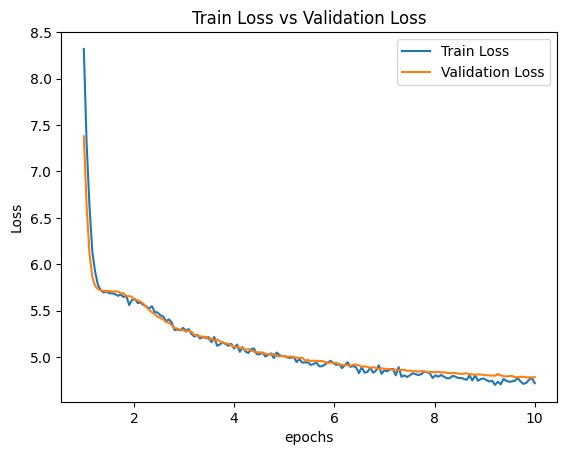

In [41]:
plt.plot(np.linspace(1,10,len(train_losses)),train_losses, label='Train Loss')
plt.plot(np.linspace(1,10,len(val_losses)),val_losses, label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Validation Loss')
plt.legend()
plt.show()

In [42]:
PATH = './'
pickle_dump(train_losses, PATH,'train_losses_10.pkl')
pickle_dump(val_losses, PATH,'val_losses_10.pkl')

In [10]:
accumulation_batches = 4
epochs = 20 

model = TransformerModel(vocab_size=len(vocab.word2index),d_model=d_model,pad_id=vocab.word2index["<PAD>"],
                        encoder_layers=encoder_layers,decoder_layers=decoder_layers,dim_feedforward=feed_forward_dim,
                        num_heads=nheads,dropout_transformer=dropout_transformer, dropout_posenconding=dropout_posenconding).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2index["<PAD>"])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',patience=patience, factor=0.8)

train_losses, val_losses, model, optimizer = train_ga(epochs, model, criterion, optimizer, train_loader,
                                                                    device, val_loader, accumulation_batches, lr_scheduler, eval_every_n_batches)

Epoch: 1/20, Batch: 32/512
Train Loss: 8.5063
Validation Loss: 8.1579
Random Target Sentence: why do mice go where there is cheese <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Random Output Sentence: <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>

Epoch: 1/20, Batch: 64/512
Train Loss: 8.0842
Validation Loss: 7.8014
Random Target Sentence: i killed him and cut him and ate all of him i left nothing for you <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Random Output Sentence: <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>

Epoch: 1/20, Batch: 96/512
Train Loss: 7.7424
Validation Loss: 7.5371
Random Target Sentence: what guy <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

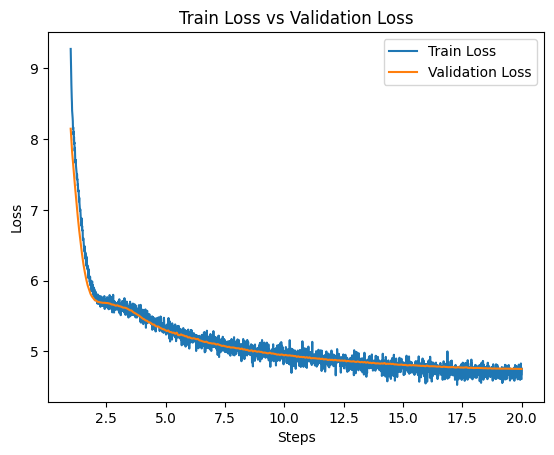

In [45]:
plt.plot(np.linspace(1,epochs,len(train_losses)),train_losses, label='Train Loss')
plt.plot(np.linspace(1,epochs,len(val_losses)),val_losses, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Train Loss vs Validation Loss')
plt.legend()
plt.show()

In [46]:
PATH = './'
pickle_dump(train_losses, PATH,'train_ga_losses_20.pkl')
pickle_dump(val_losses, PATH,'val_ga_losses_20.pkl')

In [11]:
# Checkpointing
############################

PATH = './'
save_checkpoint = checkpoint(model,optimizer,path=PATH,save_name="checkpoint_dicts")
torch.save(model, PATH+'model.pt')
#model_state, optimizer_state = load_checkpoint(PATH+"checkpoint_dicts.pt")
#model = torch.load(PATH+'model.pt')

In [41]:
def get_greedy_answer(model, question, vocab, device, max_length=20):
    line,_ = process_sentence(question)
    line = line+['<EOS>']
    line = [vocab.word2index.get(word, vocab.word2index["<PAD>"]) for word in line]
    line = torch.tensor(line, dtype=torch.long).unsqueeze(0).to(device)
    target = torch.tensor([vocab.word2index["<SOS>"]], dtype=torch.long).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        for _ in range(max_length):
            output = model(line,target)
            output = output.argmax(dim=-1)[:,-1]
            if output.item() == vocab.word2index["<EOS>"]:
                break
            target = torch.cat((target,output.unsqueeze(0)),dim=1)
    answer = " ".join([vocab.index2word[idx.item()] for idx in target.squeeze()[1:]])
    return answer



def get_topk_answers(model, question, vocab, device, k=5, max_length=20):
    line,_ = process_sentence(question)
    line = line+['<EOS>']
    line = [vocab.word2index.get(word, vocab.word2index["<PAD>"]) for word in line]
    line = torch.tensor(line).unsqueeze(0).to(device)
    target = torch.tensor([vocab.word2index["<SOS>"]], dtype=torch.long).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        for _ in range(max_length):
            output = model(line,target)
            output = F.softmax(output, dim=-1)[0,-1,:].detach().cpu()
            topk_logits, topk_indices = torch.topk(output,k=k,dim=-1)
            p = F.softmax(topk_logits, dim=-1).numpy()
            w_idx = np.random.choice(topk_indices.squeeze(), p=p)
            if w_idx == vocab.word2index["<EOS>"]:
                break
            w_idx = torch.tensor(w_idx, dtype=torch.long).unsqueeze(0).unsqueeze(0).to(device)
            target = torch.cat((target,w_idx),dim=1)
    target = [vocab.index2word[idx.item()] for idx in target.squeeze()[1:]]
    return " ".join(target)

In [43]:
input1 = "Hello sir, how are you?"
input2 = "What is your name?"
input3 = "How old are you?"
print(get_greedy_answer(model, input1, vocab, device, max_length=20))
print(get_greedy_answer(model, input2, vocab, device, max_length=20))
print(get_greedy_answer(model, input3, vocab, device, max_length=20))
print(get_topk_answers(model, input1, vocab, device, max_length=20))
print(get_topk_answers(model, input2, vocab, device, max_length=20))
print(get_topk_answers(model, input3, vocab, device, max_length=20))
print(get_topk_answers(model, input1, vocab, device, max_length=20))
print(get_topk_answers(model, input2, vocab, device, max_length=20))
print(get_topk_answers(model, input3, vocab, device, max_length=20))

i am sorry
i am sorry
i am sorry
what
you can get out of a car and you are gon
you are a lot and i do it was going
i have a minute in this time in this way to get a little way to be in your little
no no you do not know that i do
i can not know that is all right and i am going to be in your way i am a
